In [57]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from gridgraph.volt_grid import Voltage_Element, VoltageGrid
from gridgraph.volt_handlers import Dual_Diode_Handler
from gridgraph.utils import param_loader

from gridgraph.finite_grid import Element, DiffusionGrid
from gridgraph.power_handlers import lossy_handler

# Messing around with pieces of solver

In [59]:
params = param_loader('./recipes/1 cm test.csv')
params['elements_per_side'] = 2

my_grid = VoltageGrid(element_class=Voltage_Element,
                     solver_type=Dual_Diode_Handler,
                     params=params)

best power:  0.589 V
Voc: 0.6718176363440258
Joc: 3.132942517827114e-09


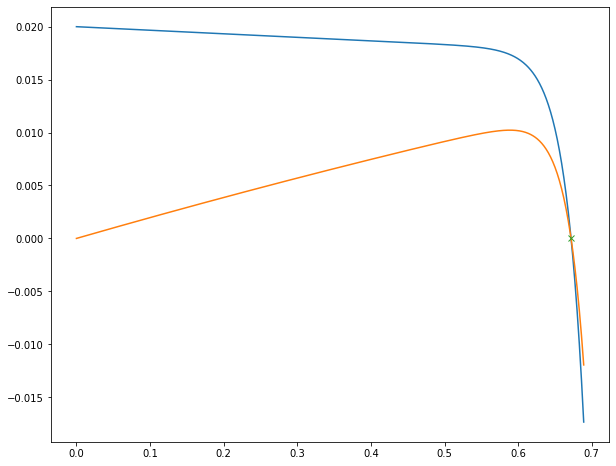

In [212]:
# Test out cvxpy Voc finder
from gridgraph.volt_grid import find_Voc
handler = Dual_Diode_Handler(params)

V = np.arange(0, .69, .001)
plt.plot(V, handler.local_Jsol(V))
plt.plot(V, V * handler.local_Jsol(V))
print('best power: ', V[np.argmax(V * handler.local_Jsol(V))], 'V')

Voc = find_Voc(handler.local_Jsol)
print('Voc:', Voc)
print('Joc:', handler.local_Jsol(Voc))
plt.plot(Voc, handler.local_Jsol(Voc), 'x')

In [61]:
# Check neighbors - should be two per node
print('Neighbors:')
print([[n.idx for n in e.neighbors] for e in my_grid.elements])

# Check targets - everything should be isolated
print('Targets:')
print([[n.idx for n in e.target] for e in my_grid.elements if (e.target is not None)])

print('Sink index:  ' + str(my_grid.sink.idx))

Neighbors:
[[1, 2], [0, 3], [0, 3], [1, 2]]
Targets:
[]
Sink index:  2


In [63]:
# Check voltages - everything should initialize to Voc
print(my_grid.Vs)

[0.6718176363440258, 0.6718176363440258, 0.6718176363440258, 0.6718176363440258]


In [65]:
# Get Current
print(my_grid.Is)

[None, None, None, None]


# Develop the integrated solver

In [502]:
params = param_loader('./recipes/1 cm test.csv')
params['elements_per_side'] = 2

my_grid = VoltageGrid(element_class=Voltage_Element,
                     solver_type=Dual_Diode_Handler,
                     params=params)

In [503]:
from autograd import grad

# Set up the graph
my_grid.elements[0].target = my_grid.sink
my_grid.elements[3].target = my_grid.sink
my_grid.elements[1].target = my_grid.elements[0]

print('Initialized Targets:')
print(['None' if e.target is None else e.target.idx for e in my_grid.elements])

dP = grad(my_grid.power)
my_grid.V = my_grid.sink.V
lr = 5e-1

Initialized Targets:
[2, 0, 'None', 2]


In [544]:
# One training iteration

power = my_grid.power(my_grid.V)
print('Voltage:', my_grid.Vs)
print('Current:', my_grid.Is)
print('Power:', power)
gradient = dP(my_grid.V)
print('dP/dV:', gradient)
my_grid.V += lr * gradient
# TODO update targets here
print('New voltage:', my_grid.V)

Voltage: [0.5873750332621026, 0.5998400026989184, 0.5774978199134815, 0.5898753170044458]
Current: [0.008302027162492447, 0.004130600435243698, 0.016641569957595987, 0.004218803876272808]
Power: Autograd ArrayBox with value 0.00961047037044937
dP/dV: 3.8261919044661275e-06
New voltage: 0.5774997330094337

